In [69]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,transforms, models
from collections import OrderedDict
import json
import shutil
import numpy as np
import pandas as pd
import time
from torch import nn
from torch import optim
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import glob
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
import os

### Introduction

Deep learning is one of the family members of the machine learning based on ar-tificial neural networks.  With the neural networks, images can be classified well.In medical image science deep learning can be used to classify the X-ray images.In this project Chest X-rays are used to classify whether Pneumonia exists.  Withthe model that can classify whether the patient has Pneumonia, doctors can reducetime to read X-ray images.  The model will give the possibility of the existence ofPneumonia, which can be used as a auxiliary diagnosis.

The problem is to create a model that can classify the chest x-ray image in termsof whether Pneumonia exists.  A deep learning method will be used, and AmazonSageMaker will be utilized.  A high level method for SageMaker training will bedeployed in building the model

The dataset is retrieved from Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.

The dataset is organized into 3 folders (train, test, val) and contains subfolders foreach image category (0/1). 0 represents Normal and 1 represents Pneumonia. Thereare 5,863 X-Ray images (JPEG).

The benchmark model can be found in Kaggle. The best model in Kaggle Kernelsright now has recall ratio 0.98 and precision ratio 0.79. My goal is to get the similarresult based on the same test dataset.

Accuracy ratio, recall ratio and precision ratio can be used to evaluate the modelperformance.  In this case recall ratio should be focused on since the number ofFalse Negatives should be as low as possible but accuracy ratio should also be considered. Thus the trade off between recall and precision ratio will be considered.

### 1. Explore the dataset and data preprocessing

In [2]:
# Load the data
data_dir = 'chest_xray'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

First we should get the list of the picture names and label the pictures

In [3]:
# File route
train_normal = train_dir + '/0'
train_pneumonia = train_dir + '/1'

# Get the list of all the images
train_normal_list = glob.glob(train_normal + '/*.jpeg')
train_pneumonia_list = glob.glob(train_pneumonia + '/*.jpeg')

# label the train data
df1 = pd.DataFrame(train_normal_list)
df1['pneumonia'] = np.zeros(len(df1))
df2 = pd.DataFrame(train_pneumonia_list)
df2['pneumonia'] = np.ones(len(df2))
df_train = df1.append(df2).reset_index(drop = True)
df_train.columns = ('Pic','pneumonia')
df_train = df_train.sample(frac=1, random_state=2020).reset_index(drop=True) # shuffle the dataset
df_train.head()

,Pic,pneumonia
0,chest_xray/train/1/person1079_bacteria_3019.jpeg,1.0
1,chest_xray/train/1/person586_bacteria_2420.jpeg,1.0
2,chest_xray/train/0/NORMAL2-IM-1008-0001.jpeg,0.0
3,chest_xray/train/1/person1604_virus_2782.jpeg,1.0
4,chest_xray/train/1/person28_bacteria_143.jpeg,1.0


In [4]:
# Do the same thing to the validation and the test dataset
# File route
valid_normal = valid_dir + '/0'
valid_pneumonia = valid_dir + '/1'

# Get the list of all the images
valid_normal_list = glob.glob(valid_normal + '/*.jpeg')
valid_pneumonia_list = glob.glob(valid_pneumonia + '/*.jpeg')

# label the train data
df1 = pd.DataFrame(valid_normal_list)
df1['pneumonia'] = np.zeros(len(df1))
df2 = pd.DataFrame(valid_pneumonia_list)
df2['pneumonia'] = np.ones(len(df2))
df_valid = df1.append(df2).reset_index(drop = True)
df_valid.columns = ('Pic','pneumonia')
df_valid = df_valid.sample(frac=1, random_state=20).reset_index(drop=True) # shuffle the dataset
df_valid.head()

,Pic,pneumonia
0,chest_xray/valid/0/IM-0129-0001.jpeg,0.0
1,chest_xray/valid/0/IM-0156-0001.jpeg,0.0
2,chest_xray/valid/0/IM-0127-0001.jpeg,0.0
3,chest_xray/valid/1/person124_virus_238.jpeg,1.0
4,chest_xray/valid/1/person122_virus_229.jpeg,1.0


In [5]:
# File route
test_normal = test_dir + '/0'
test_pneumonia = test_dir + '/1'

# Get the list of all the images
test_normal_list = glob.glob(test_normal + '/*.jpeg')
test_pneumonia_list = glob.glob(test_pneumonia + '/*.jpeg')

# label the train data
df1 = pd.DataFrame(test_normal_list)
df1['pneumonia'] = np.zeros(len(df1))
df2 = pd.DataFrame(test_pneumonia_list)
df2['pneumonia'] = np.ones(len(df2))
df_test = df1.append(df2).reset_index(drop = True)
df_test.columns = ('Pic','pneumonia')
df_test = df_test.sample(frac=1, random_state=20).reset_index(drop=True) # shuffle the dataset
df_test.head()

,Pic,pneumonia
0,chest_xray/test/1/person103_bacteria_489.jpeg,1.0
1,chest_xray/test/0/NORMAL2-IM-0030-0001.jpeg,0.0
2,chest_xray/test/1/person83_bacteria_412.jpeg,1.0
3,chest_xray/test/1/person57_virus_113.jpeg,1.0
4,chest_xray/test/0/IM-0017-0001.jpeg,0.0


Text(1, 3861, '3861')

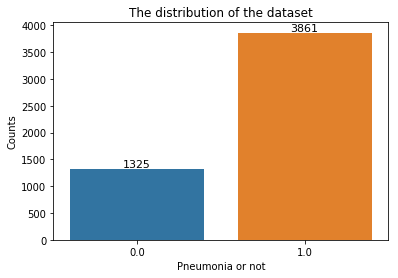

In [6]:
# Then we can see the distribution of our train dataset
counts = df_train.pneumonia.value_counts()
sns.barplot(x=counts.index, y= counts.values)
plt.title('The distribution of the dataset')
plt.xlabel('Pneumonia or not') 
plt.ylabel('Counts') 
plt.text(0,counts.values[1], '%.0f' % counts.values[1], ha='center', va= 'bottom',fontsize=11)  
plt.text(1,counts.values[0], '%.0f' % counts.values[0], ha='center', va= 'bottom',fontsize=11) 

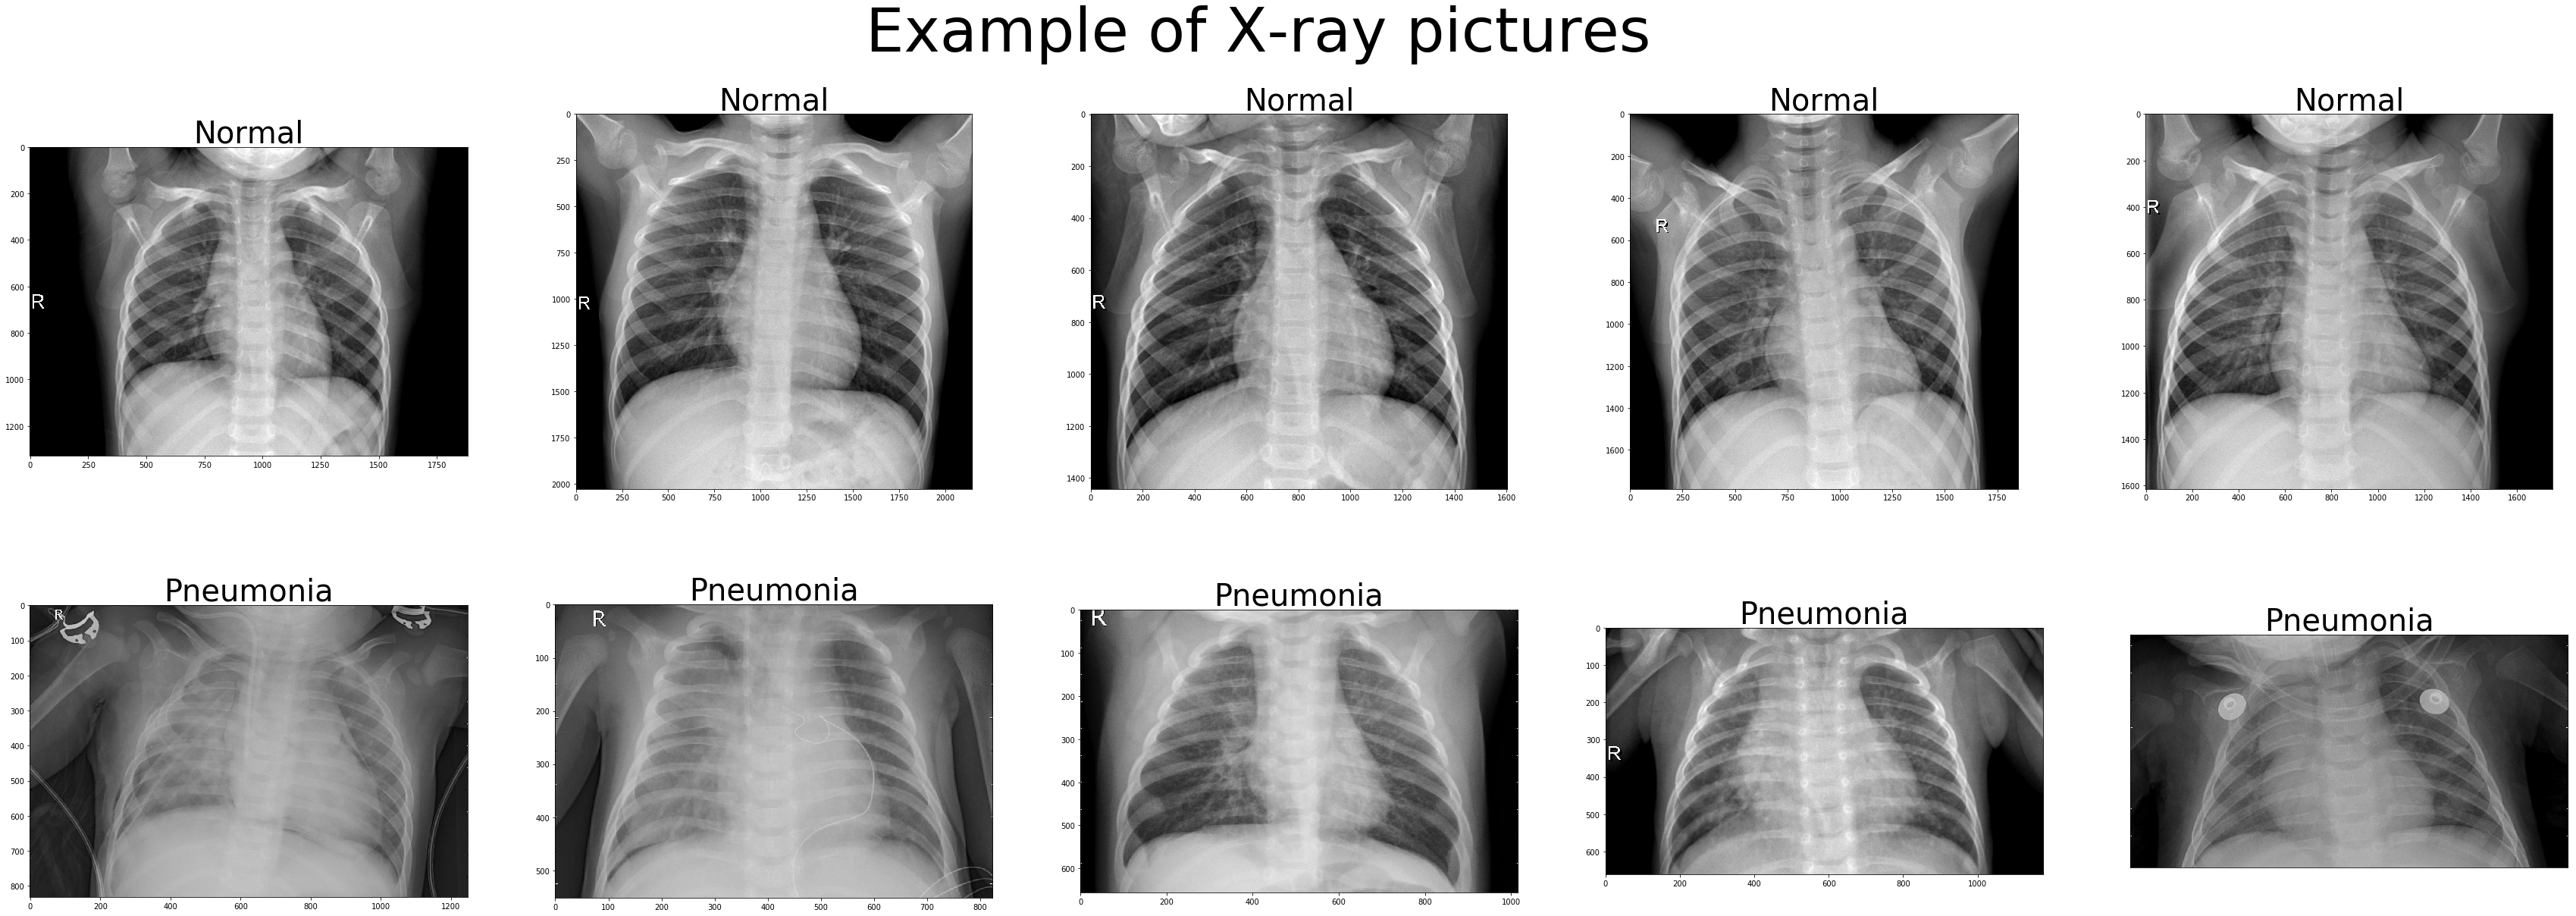

In [7]:
# It is also a good idea to look some examples of the X-ray pictures.

pic_list = df_train[df_train['pneumonia']==0].head()['Pic']
pic_list = pic_list.append(df_train[df_train['pneumonia']==1].head()['Pic'])
pic_list = pic_list.reset_index(drop=True)

fig, ax = plt.subplots(2,5, figsize=(60,20))
for i in range(1,11):
    img = Image.open(pic_list[i-1])
    if i <= 5:
        ax[0,i-1].imshow(img, cmap='gray')
        ax[0,i-1].set_title('Normal',fontsize=40)
    else:
        ax[1,i-6].imshow(img, cmap='gray')
        ax[1,i-6].set_title('Pneumonia',fontsize=40)
    plt.xticks([])
    plt.yticks([])
fig.suptitle('Example of X-ray pictures', fontsize=80)
plt.show()

Next we should preprocessing our dataset in order to fit the requirements of the model. In this case, we should create dictionaries such that each file name corresponds to the correct label.

In [55]:
# create annotations for train 
train_annotations = []
for each in df_train['Pic']:
    each = each.strip('chest_xray/train/1/')
    each = each.strip('chest_xray/train/0/')
    train_annotations.append(each)
train_annotations = pd.DataFrame([train_annotations,df_train['pneumonia']]).T
train_annotations = dict(train_annotations.values.tolist())
len(train_annotations)

5186

In [106]:
# create annotations for validation
valid_annotations = []
for each in df_valid['Pic']:
    each = each.strip('chest_xray/valid/1/')
    each = each.strip('chest_xray/valid/0/')
    valid_annotations.append(each)
valid_annotations = pd.DataFrame([valid_annotations,df_valid['pneumonia']]).T
valid_annotations = dict(valid_annotations.values.tolist())
len(valid_annotations)

46

In [61]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in valid_annotations.items():
    all_annotations[key] = value
len(all_annotations)

5232

In [62]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

[0.0, 1.0]

Num of classes: 2


We have 5232 training images and 46 validation images with two classes.

### 2. Upload the training data to S3

In [63]:
# session and role
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
container = get_image_uri(boto3.Session().region_name, 'image-classification')
print(container)

825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:1


Then we should prepare the dataset in specific folders so that these data can be uploaded to S3

In [33]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

After four folders are created we should transfer data in each folder and create annotation files with .lst

In [103]:
import re 
def prepare_data_train(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            match = re.match(r'person', image)
            if match:
                shutil.copy(os.path.join('chest_xray/train/1/', image), os.path.join(key, image))
            else:
                shutil.copy(os.path.join('chest_xray/train/0/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()
    
def prepare_data_valid(annotations, key='validation'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            match = re.match(r'person', image)
            if match:
                shutil.copy(os.path.join('chest_xray/valid/1/', image), os.path.join(key, image))
            else:
                shutil.copy(os.path.join('chest_xray/valid/0/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [96]:
prepare_data_train(train_annotations, 'train')

100%|██████████| 5186/5186 [01:28<00:00, 58.46it/s] 


In [108]:
prepare_data_valid(valid_annotations, 'validation')

100%|██████████| 46/46 [00:01<00:00, 44.83it/s]


Finally we can upload our prepared files to the S3.

In [110]:
%%time

s3_train_path = sess.upload_data(path='train',bucket=bucket, key_prefix='train')
print('Training images uploaded')
s3_train_lst_path = sess.upload_data(path='train_lst',bucket=bucket, key_prefix='train_lst')
print('Training list uploaded')
s3_validation_path = sess.upload_data(path='validation',bucket=bucket, key_prefix='validation')
print('validation images uploaded')
s3_validation_lst_path = sess.upload_data(path='validation_lst',bucket=bucket, key_prefix='validation_lst')
print('Validation list uploaded')

Training images uploaded
Training list uploaded
validation images uploaded
Validation list uploaded
CPU times: user 37.8 s, sys: 3.4 s, total: 41.2 s
Wall time: 5min 3s


### SageMaker Estimator

Then we should set up our model with parameters and hyperparameters.

In [111]:
prefix = 'output'
output_path = 's3://{}/{}'.format(bucket, prefix)
model = sagemaker.estimator.Estimator(
    container,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    train_max_run=36000,
    input_mode='File',
    output_path=output_path,
    sagemaker_session=sess
)

In [113]:
# Hyperparameters
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=2,
    mini_batch_size=32,
    resize=224,
    epochs=10,
    learning_rate=0.001,
    num_training_samples=5186,
    augmentation_type='crop_color_transform'
)

In [114]:
# Data channels
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated',
                                       content_type='application/x-image',s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                                       content_type='application/x-image',s3_data_type='S3Prefix')
train_lst_data = sagemaker.session.s3_input(s3_train_lst_path, distribution='FullyReplicated',
                                       content_type='application/x-image',s3_data_type='S3Prefix')
validation_lst_data = sagemaker.session.s3_input(s3_validation_lst_path, distribution='FullyReplicated',
                                       content_type='application/x-image',s3_data_type='S3Prefix')

In [115]:
data_channels = {
    'train': train_data,
    'train_lst': train_lst_data,
    'validation': validation_data,
    'validation_lst': validation_lst_data
}

### Model training

In [116]:
model.fit(inputs=data_channels,logs=True)

2020-03-19 12:19:59 Starting - Starting the training job...
2020-03-19 12:20:00 Starting - Launching requested ML instances...
2020-03-19 12:20:58 Starting - Preparing the instances for training.........
2020-03-19 12:22:21 Downloading - Downloading input data.........
2020-03-19 12:23:35 Training - Downloading the training image.Docker entrypoint called with argument(s): train
[03/19/2020 12:24:06 INFO 140362814187328] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[03/19/2020 12:24:06 INFO 140362814187328] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'l

[03/19/2020 12:26:50 INFO 140362814187328] Epoch[2] Batch [120]#011Speed: 151.696 samples/sec#011accuracy=0.967200
[03/19/2020 12:26:55 INFO 140362814187328] Epoch[2] Batch [140]#011Speed: 151.687 samples/sec#011accuracy=0.968750
[03/19/2020 12:26:59 INFO 140362814187328] Epoch[2] Batch [160]#011Speed: 151.792 samples/sec#011accuracy=0.968750
[03/19/2020 12:26:59 INFO 140362814187328] Epoch[2] Train-accuracy=0.968943
[03/19/2020 12:26:59 INFO 140362814187328] Epoch[2] Time cost=33.940
[03/19/2020 12:26:59 INFO 140362814187328] Epoch[2] Validation-accuracy=1.000000
[03/19/2020 12:27:04 INFO 140362814187328] Epoch[3] Batch [20]#011Speed: 149.634 samples/sec#011accuracy=0.953869
[03/19/2020 12:27:08 INFO 140362814187328] Epoch[3] Batch [40]#011Speed: 150.875 samples/sec#011accuracy=0.966463
[03/19/2020 12:27:12 INFO 140362814187328] Epoch[3] Batch [60]#011Speed: 151.211 samples/sec#011accuracy=0.969262
[03/19/2020 12:27:16 INFO 140362814187328] Epoch[3] Batch [80]#011Speed: 151.308 sample

[03/19/2020 12:30:40 INFO 140362814187328] Epoch[9] Batch [60]#011Speed: 150.594 samples/sec#011accuracy=0.982070
[03/19/2020 12:30:44 INFO 140362814187328] Epoch[9] Batch [80]#011Speed: 150.669 samples/sec#011accuracy=0.983025
[03/19/2020 12:30:48 INFO 140362814187328] Epoch[9] Batch [100]#011Speed: 150.734 samples/sec#011accuracy=0.983911
[03/19/2020 12:30:52 INFO 140362814187328] Epoch[9] Batch [120]#011Speed: 150.804 samples/sec#011accuracy=0.985021
[03/19/2020 12:30:56 INFO 140362814187328] Epoch[9] Batch [140]#011Speed: 150.897 samples/sec#011accuracy=0.985816
[03/19/2020 12:31:01 INFO 140362814187328] Epoch[9] Batch [160]#011Speed: 150.967 samples/sec#011accuracy=0.986219
[03/19/2020 12:31:01 INFO 140362814187328] Epoch[9] Train-accuracy=0.985918
[03/19/2020 12:31:01 INFO 140362814187328] Epoch[9] Time cost=34.127
[03/19/2020 12:31:01 INFO 140362814187328] Epoch[9] Validation-accuracy=1.000000

2020-03-19 12:31:19 Uploading - Uploading generated training model
2020-03-19 12:31:1

### Deploy the model

In [117]:
deployed_model = model.deploy(initial_instance_count=1,instance_type='ml.t2.medium')
print('\nModel deployed!')

-------------------!
Model deployed!


### Predictions

In [123]:
image_dir = 'chest_xray/test/0'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
print(len(images))

234


In [124]:
deployed_model.content_type = 'image/jpeg'

In [129]:
index = 233

image_path = os.path.join(image_dir, images[index])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())
    
result = deployed_model.predict(b)
result = json.loads(result)
print(result)

[0.99014812707901, 0.009851922281086445]


The result above returns a possibility distribution of zero and one we can simply choose the highest one as the predicted result.

In [130]:
classes[np.argmax(result)]

0.0

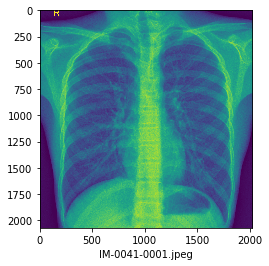

In [131]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

In [143]:
# Also try a pneumonia
image_dir = 'chest_xray/test/1'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
print(len(images))

390


In [145]:
deployed_model.content_type = 'image/jpeg'
index = 1
image_path = os.path.join(image_dir, images[index])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())
    
result = deployed_model.predict(b)
result = json.loads(result)
print(result)

[0.0011476683430373669, 0.9988523721694946]


In [146]:
classes[np.argmax(result)]

1.0

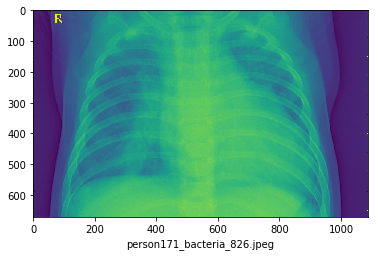

In [147]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

The estimates of those examples are correct but we still need to use the remainder test set to calculate the recall and accuracy ratios in order to test our model performence.

### Assess the performance

In [201]:
# All should be zeros, which means normal
image_dir = 'chest_xray/test/0'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
deployed_model.content_type = 'image/jpeg'
normals = []
for i in range(0,233):
    index = i
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    result = deployed_model.predict(b)
    result = json.loads(result)
    normals.append(classes[np.argmax(result)])

In [202]:
false_pos = sum(normals) 
true_neg = len(normals) - false_neg

In [203]:
# All should be ones, which means pneumonia
image_dir = 'chest_xray/test/1'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
deployed_model.content_type = 'image/jpeg'
pneumonia = []
for i in range(0,389):
    index = i
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    result = deployed_model.predict(b)
    result = json.loads(result)
    pneumonia.append(classes[np.argmax(result)])

In [204]:
true_pos = sum(pneumonia) 
false_neg = len(pneumonia) - true_pos

In [205]:
df = pd.DataFrame({'predict 0': [true_neg, false_neg],
                   'predict 1': [false_pos, true_pos],},
                  index=['true 0','true 1'])
df

,predict 0,predict 1
true 0,190.0,26.0
true 1,49.0,340.0


In [206]:
# ratios
accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
recall = true_pos/(true_pos+false_neg)
precision = true_pos/(true_pos+false_pos)
print("{:<11} {:.3f}".format('Accuracy:', accuracy))
print("{:<11} {:.3f}".format('Recall:', recall))
print("{:<11} {:.3f}".format('Precision:', precision))

Accuracy:   0.876
Recall:     0.874
Precision:  0.929


In this task, recall ratio should be as higher as possible. Based on our model predictions, the recall ratio is nearly 87.5%, which is pretty good. However, if the model will be used in reality the recall ratio should be improved such that number of the miss diagnosis will decrease. Because miss diagnosis will do harm to the patients but false postive can be double checked by the doctor. Next we should improve the recall ratio based on the cutoff values.

### Improve the performance of the model

In [207]:
cutoff = 0.2 # set the cutoff value
# All should be zeros, which means normal
image_dir = 'chest_xray/test/0'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
deployed_model.content_type = 'image/jpeg'
normals = []
for i in range(0,233):
    index = i
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    result = deployed_model.predict(b)
    result = json.loads(result)
    if result[1] > cutoff:
        normals.append(1)
    else:
        normals.append(0)
false_pos = sum(normals) 
true_neg = len(normals) - false_neg

In [208]:
# All should be ones, which means pneumonia
image_dir = 'chest_xray/test/1'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
deployed_model.content_type = 'image/jpeg'
pneumonia = []
for i in range(0,389):
    index = i
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    result = deployed_model.predict(b)
    result = json.loads(result)
    if result[1] > cutoff:
        pneumonia.append(1)
    else:
        pneumonia.append(0)
true_pos = sum(pneumonia) 
false_neg = len(pneumonia) - true_pos

In [209]:
df = pd.DataFrame({'predict 0': [true_neg, false_neg],
                   'predict 1': [false_pos, true_pos],},
                  index=['true 0','true 1'])
df

,predict 0,predict 1
true 0,184.0,43
true 1,20.0,369


In [210]:
# ratios
accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
recall = true_pos/(true_pos+false_neg)
precision = true_pos/(true_pos+false_pos)
print("{:<11} {:.3f}".format('Accuracy:', accuracy))
print("{:<11} {:.3f}".format('Recall:', recall))
print("{:<11} {:.3f}".format('Precision:', precision))

Accuracy:   0.898
Recall:     0.949
Precision:  0.896


When we set the cutoff value equals 0.2, the recall ratio improves to nearly 95%. What is worth to mention is that the precision ratio only decreased a little bit to 89.6%. Therefore, the overall accuracy ratio improves. It is good to choose a relatively lower cutoff value. The usual cutoff value is 0.5 but in this diagnostic problem we should choose realatively lower cutoff value in order to decrease the number of false negtives.

Compared with benchmark model in Kaggle, we have relatively simliar results.

The limitation in this analysis will be the small dataset. This dataset only has nearly 6000 pictures, which is clearly not enough to get an elaborate model. However, the methods and ideas used in this analysis is useful for further analysis when we have more data.

### Delete the endpoint

In [212]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)